In [3]:
import h5py
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

In [2]:
fname = 'skopi_experiment/SPI_7dx9_1k_quadruple.h5'
fig = h5py.File(fname, 'r')

OSError: Unable to open file (unable to open file: name = 'skopi_experiment/7dx9/SPI_7dx9_1k_quadruple.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [86]:
list(fig.keys())

['orientations',
 'photons',
 'pixel_index_map',
 'pixel_position_reciprocal',
 'volume']

In [87]:
print(fig['photons'].shape)

(4000, 4, 512, 512)


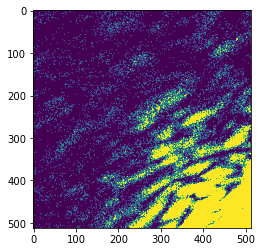

In [88]:
plt.imshow(fig['photons'][999][0], vmin=0, vmax=10)

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import h5py as h5
import time, os
import skopi as sk

In [17]:
import skimage.measure as sm

from numba import jit
# Upsampling
@jit(nopython=True)
def upsample(warr, dim, binr, binc):
    upCalib = np.zeros(dim)
    #for k in range(dim[0]):
    for i, ix in enumerate(range(0,dim[0],binr)):
        if ix+binr > dim[0]:
            er = dim[0]+1
        else:
            er = ix+binr
        for j, jy in enumerate(range(0,dim[1],binc)):
            if jy+binc > dim[1]:
                ec = dim[1]+1
            else:
                ec = jy+binc
            upCalib[ix:er,jy:ec] = warr[i,j]
    return upCalib

# perform binning here
def downsample(assem, bin_row=2, bin_col=2, mask=None):
    if mask is None:
        combinedMask = np.ones_like(assem)
    else:
        combinedMask = mask
    downCalib = sm.block_reduce(assem, block_size=(bin_row, bin_col), func=np.sum)
    downWeight = sm.block_reduce(combinedMask, block_size=(bin_row, bin_col), func=np.sum)
    warr = np.zeros_like(downCalib, dtype='float32')
    ind = np.where(downWeight > 0)
    warr[ind] = downCalib[ind] / downWeight[ind]
    return warr
#upCalib = upsample(warr, calib.shape, binr, binc)

In [89]:
################# Change these accordingly
beamfile = '../examples/input/beam/amo86615.beam'
particlefile = '../examples/input/pdb/7dx9.pdb'
geom = '../examples/input/lcls/amo86615/PNCCD::CalibV1/Camp.0:pnCCD.1/geometry/0-end.data'

increase_factor = 1000
n_pixels, det_size, det_dist = (1024, 0.08, 0.29050000000000076)

# !!!!!!! Remember to change this
n_part_per_shot = 4
# !!!!!!!

#################

beam = sk.Beam(beamfile)
beam.set_photons_per_pulse(increase_factor *beam.get_photons_per_pulse())

particle = sk.Particle()
particle.read_pdb(particlefile, ff='WK')

det = sk.PnccdDetector(geom=geom, beam=beam)
det.distance = float(det_dist)

# det = sk.SimpleSquareDetector(int(n_pixels), float(det_size), float(det_dist), beam=beam)

exp = sk.SPIExperiment(det, beam, particle, n_part_per_shot)

pattern = exp.generate_image_stack(return_photons=True,return_intensities=False)

Generating particle 2 of 4
Generating particle 2 of 4
Generating particle 2 of 4
Generating particle 2 of 4
Generating particle 2 of 4
Generating particle 2 of 4
Generating particle 2 of 4
Generating particle 2 of 4
Generating particle 2 of 4
Generating particle 2 of 4
Generating particle 2 of 4
Generating particle 2 of 4
Generating particle 2 of 4
Generating particle 2 of 4
Generating particle 2 of 4
Generating particle 3 of 4
Generating particle 3 of 4
Generating particle 3 of 4
Generating particle 3 of 4
Generating particle 3 of 4
Generating particle 3 of 4
Generating particle 3 of 4
Generating particle 3 of 4
Generating particle 3 of 4
Generating particle 3 of 4
Generating particle 3 of 4
Generating particle 3 of 4
Generating particle 3 of 4
Generating particle 3 of 4
Generating particle 3 of 4
Generating particle 4 of 4
Generating particle 4 of 4
Generating particle 4 of 4
Generating particle 4 of 4


In [90]:
###### Run this cell to create thumbnail files ######
mask = det.assemble_image_stack(np.ones_like(pattern))
# mask = None
f = h5py.File(fname,'r')
dset = f['photons']

i = 1
img = downsample(det.assemble_image_stack(dset[i]), bin_row=8, bin_col=8, mask=mask)
fout = h5py.File(fname.split(".h5")[0]+'_thumbnail.h5','w')
ds = fout.create_dataset('photons', (1000, img.shape[0],img.shape[1]), dtype='float32')
for i in range(1000):
    img = downsample(det.assemble_image_stack(dset[i]), bin_row=8, bin_col=8, mask=mask)
    ds[i,:,:] = img
fout.close()

In [5]:
#####
thumbnail_name = 'skopi_experiment/7dx9/SPI_7dx9_1k_quadruple_thumbnail.h5'
# thumbnail_name = 'scatch_output/SPI_3iyf_1k_single_thumbnail.h5'
#####

thumbnail = h5py.File(thumbnail_name, 'r')

In [31]:
'''
Parameters
----------
image : ndarray
    Input image data. Will be converted to float.
mode : str
    One of the following strings, selecting the type of noise to add:

    'gauss'     Gaussian-distributed additive noise.
    'poisson'   Poisson-distributed noise generated from the data.
    's&p'       Replaces random pixels with 0 or 1.
    'speckle'   Multiplicative noise using out = image + n*image,where
                n is uniform noise with specified mean & variance.
'''

import numpy as np
import os
import cv2
def noisy(noise_typ,image):
    if noise_typ == "gauss":
        row,col= image.shape
        mean = 0
        var = 0.1
        sigma = var**0.5
        gauss = np.random.normal(mean,sigma,(row,col))
        gauss = gauss.reshape(row,col)
        noisy = image + gauss
        return noisy
    elif noise_typ == "s&p":
        row,col = image.shape
        s_vs_p = 0.5
        amount = 0.004
        out = np.copy(image)
        # Salt mode
        num_salt = np.ceil(amount * image.size * s_vs_p)
        coords = [np.random.randint(0, i - 1, int(num_salt))
              for i in image.shape]
        out[coords] = 1

        # Pepper mode
        num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
        coords = [np.random.randint(0, i - 1, int(num_pepper))
              for i in image.shape]
        out[coords] = 0
        return out
    elif noise_typ == "poisson":
        vals = len(np.unique(image))
        vals = 2 ** np.ceil(np.log2(vals))
        noisy = np.random.poisson(image * vals) / float(vals)
        return noisy
    elif noise_typ =="speckle":
        row,col = image.shape
        gauss = np.random.randn(row,col)
        gauss = gauss.reshape(row,col)        
        noisy = image + image * gauss
        return noisy

In [48]:
import random
def sp_noise(image,prob):
    '''
    Add salt and pepper noise to image
    prob: Probability of the noise
    '''
    output = np.zeros(image.shape,np.uint8)
    thres = 1 - prob 
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            rdn = random.random()
            if rdn < prob:
                output[i][j] = 0
            elif rdn > thres:
                output[i][j] = 255
            else:
                output[i][j] = image[i][j]
    return output

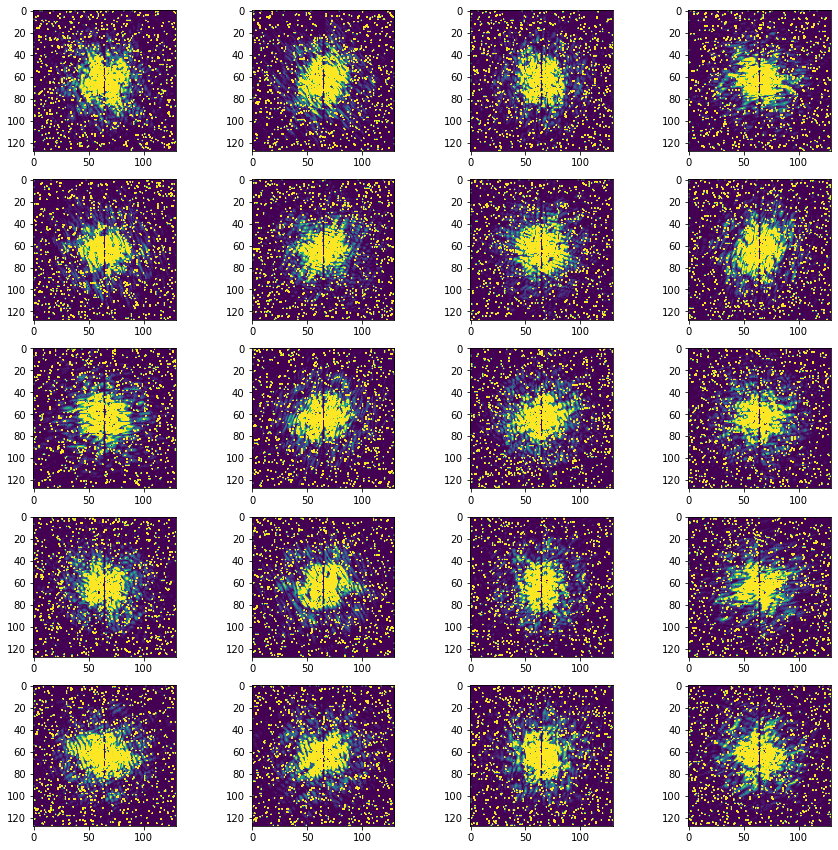

In [50]:
dset = thumbnail['photons']
w=20
h=20
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 5

for i in range(1, columns*rows +1):
    img = dset[5* i]
    img = sp_noise(img, prob=0.05)

#     # Normalize the images
#     mean_vals = np.mean(img)
#     varriance_vals = np.var(img)
#     img = (img - mean_vals) / varriance_vals

    fig.add_subplot(rows, columns, i)
    plt.imshow(img, vmin=0, vmax=25)